In [3]:
# Data
import pandas as pd
import numpy as np
from pandas_datareader import data, wb

# GIS & maps
import geopandas as gpd
gp = gpd
import georasters as gr
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import textwrap

In [4]:
# Data Munging
from itertools import product, combinations
import difflib
import pycountry
import geocoder
from geonamescache.mappers import country
mapper = country(from_key='name', to_key='iso3')
mapper2 = country(from_key='iso3', to_key='iso')
mapper3 = country(from_key='iso3', to_key='name')

# Regressions & Stats
from scipy.stats import norm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation

In [5]:
# Paths
pathout = './data/'

if not os.path.exists(pathout):
    os.mkdir(pathout)
    
pathgraphs = './graphs/'
if not os.path.exists(pathgraphs):
    os.mkdir(pathgraphs)

In [6]:
currentYear = datetime.now().year
year = min(2020, currentYear-2)

# Getting WDI data from the World Bank

* [Head over to the WDI Indicator website](https://data.worldbank.org/indicator) 

* Search for the variable you are interested in

    (e.g., **GDP per capita, PPP (constant 2017 international $)**)

* The link will become [https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD)

    (if feasible it will display a figure)

In [7]:
url = 'https://data.worldbank.org/share/widget?indicators=NY.GDP.PCAP.PP.KD'
IFrame(url, width=500, height=300)

# Downloading the data

* Suboptimal: Download from the website 

    (Not best approach, since you need to do it for every variable every time data is updated)

* Using API: Let's instead use the wonderful [pandas-data-reader package](https://pandas-datareader.readthedocs.io/en/latest/index.html)

# <font size="30">WDI with</font>
# <center> <a href="https://pandas-datareader.readthedocs.io/en/latest/index.html"><img src="https://pandas-datareader.readthedocs.io/en/latest/_static/pandas-datareader-plain.svg" alt="pandas-data-reader" width=700/></a></center>

In [8]:
url = 'https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-wb'
IFrame(url, width=800, height=400)

## Steps

1. Import **pandas-data-reader**
```python
from pandas_datareader import data, wb
```

2. Download basic country/aggregates information
```python
wbcountries = wb.get_countries()
```

In [86]:
wbcountries.head()

iso3c iso2c         name                      region                                    adminregion          incomeLevel     lendingType       capitalCity  longitude  latitude
0   ABW    AW        Aruba  Latin America & Caribbean                                                          High Income  Not classified        Oranjestad   -70.0167  12.51670
1   AFG    AF  Afghanistan                  South Asia                                     South Asia           Low Income             IDA             Kabul    69.1761  34.52280
2   AGO    AO       Angola         Sub-Saharan Africa      Sub-Saharan Africa (excluding high income)  Lower Middle Income            IBRD            Luanda    13.2420  -8.81155
3   ALB    AL      Albania       Europe & Central Asia  Europe & Central Asia (excluding high income)  Upper Middle Income            IBRD            Tirane    19.8172  41.33170
4   AND    AD      Andorra       Europe & Central Asia                                                         High Income  Not classified  Andorra la Vella     1.5218  42.50750

3. Clean up
```python
# If you want to keep aggregate data for regions or world comment out next line
wbcountries = wbcountries.loc[wbcountries.region.isin(['Aggregates'])==False].reset_index(drop=True)
wbcountries['name'] = wbcountries.name.str.strip()
wbcountries['incomeLevel'] = wbcountries['incomeLevel'].str.title()
wbcountries.loc[wbcountries.iso3c=='VEN', 'incomeLevel'] = 'Upper Middle Income'
```

In [9]:
wbcountries = wb.get_countries()
wbcountries = wbcountries.loc[wbcountries.region.isin(['Aggregates'])==False].reset_index(drop=True)
wbcountries['name'] = wbcountries.name.str.strip()
wbcountries['incomeLevel'] = wbcountries['incomeLevel'].str.title()
wbcountries.loc[wbcountries.iso3c=='VEN', 'incomeLevel'] = 'Upper Middle Income'

4. Get Indicators of interest

* Few and varied indicators of interest: 
    
    Search for the variable on the WDI Indicator website (as explained above)
        
    (e.g., [https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD))
        
    Add the indicator's name into a list of indicators in **Python**

    (i.e., everything that comes after **https://data.worldbank.org/indicator/**. E.g., `NY.GDP.PCAP.PP.KD`)
        

```python
wdi_indicators = ['NY.GDP.PCAP.PP.KD', 'NY.GDP.PCAP.KD', 'SL.GDP.PCAP.EM.KD', 'SP.POP.GROW', 'SP.POP.TOTL', 'SP.DYN.WFRT', 'SP.DYN.TFRT.IN']
```

In [10]:
wdi_indicators = ['NY.GDP.PCAP.PP.KD', 'NY.GDP.PCAP.KD', 'SL.GDP.PCAP.EM.KD', 'SP.POP.GROW', 'SP.POP.TOTL', 'SP.DYN.WFRT', 'SP.DYN.TFRT.IN']

* Many related indicators or mass search

    (e.g., search for all variables containing the word *population*)

```python
popvars = wb.search(string='population')
```
    
This returns a dataframe, where the column `id` has the IDs for the indicators

In [11]:
popvars = wb.search(string='population')
popvars.head()

id                                               name unit                      source                                         sourceNote  \
24      1.1_ACCESS.ELECTRICITY.TOT      Access to electricity (% of total population)       Sustainable Energy for All  Access to electricity is the percentage of pop...   
39    1.2_ACCESS.ELECTRICITY.RURAL      Access to electricity (% of rural population)       Sustainable Energy for All  Access to electricity is the percentage of rur...   
40    1.3_ACCESS.ELECTRICITY.URBAN      Access to electricity (% of urban population)       Sustainable Energy for All  Access to electricity is the percentage of tot...   
161             2.1_ACCESS.CFT.TOT  Access to Clean Fuels and Technologies for coo...       Sustainable Energy for All                                                      
1152           BAR.NOED.1519.FE.ZS  Barro-Lee: Percentage of female population age...             Education Statistics  Percentage of female population age 15-19 with...   

                                     sourceOrganization      topics  
24    b'World Bank Global Electrification Database 2...              
39    b'World Bank Global Electrification Database 2...              
40    b'World Bank Global Electrification Database 2...              
161                                                 b''              
1152  b'Robert J. Barro and Jong-Wha Lee: http://www...  Education

5. Download data for selected indicators, years, and countries

```python
wdi = wb.download(indicator=wdi_indicators,
                  country=list_of_countries_ISO_A2_codes, 
                  start=start_year, 
                  end=end_year)
```

6. Clean up and process data
```python
wdi = wdi.reset_index()
wdi['year'] = wdi.year.astype(int)
```

In [12]:
wdi = wb.download(indicator=wdi_indicators, country=wbcountries.iso2c.values, start=1950, end=year)
wdi = wdi.reset_index()
wdi['year'] = wdi.year.astype(int)
wdi['gdp_pc'] = wdi['NY.GDP.PCAP.PP.KD']
wdi['ln_gdp_pc'] = wdi['NY.GDP.PCAP.PP.KD'].apply(np.log)
wdi['ln_pop'] = wdi['SP.POP.TOTL'].apply(np.log)
wdi.head()

/Users/ozak/anaconda3/envs/GeoPython310env/lib/python3.10/site-packages/pandas_datareader/wb.py:592: UserWarning: Non-standard ISO country codes: JG, XK


country  year  NY.GDP.PCAP.PP.KD  NY.GDP.PCAP.KD  SL.GDP.PCAP.EM.KD  SP.POP.GROW  SP.POP.TOTL  SP.DYN.WFRT  SP.DYN.TFRT.IN        gdp_pc  ln_gdp_pc     ln_pop
0   Aruba  2020       33155.243239    25823.634941                NaN     0.134255     106585.0          NaN           1.325  33155.243239  10.408956  11.576698
1   Aruba  2019       40780.516485    31762.733960                NaN     0.451970     106442.0          NaN           1.486  40780.516485  10.615960  11.575356
2   Aruba  2018       40706.749216    31705.278824                NaN     0.494795     105962.0          NaN           1.587  40706.749216  10.614149  11.570836
3   Aruba  2017       38865.188195    30270.941601                NaN     0.537296     105439.0          NaN           1.839  38865.188195  10.567854  11.565888
4   Aruba  2016       37043.698152    28852.237067                NaN     0.590062     104874.0          NaN           1.953  37043.698152  10.519854  11.560515

7. Add other WB data from the ``wbcountries`` dataframe
```python
wdi = wbcountries.merge(wdi, left_on='name', right_on='country')
```

In [13]:
wdi = wbcountries.merge(wdi, left_on='name', right_on='country')
wdi.head()

iso3c iso2c   name                      region adminregion  incomeLevel     lendingType capitalCity  longitude  latitude  ... NY.GDP.PCAP.PP.KD  NY.GDP.PCAP.KD  \
0   ABW    AW  Aruba  Latin America & Caribbean               High Income  Not classified  Oranjestad   -70.0167   12.5167  ...      33155.243239    25823.634941   
1   ABW    AW  Aruba  Latin America & Caribbean               High Income  Not classified  Oranjestad   -70.0167   12.5167  ...      40780.516485    31762.733960   
2   ABW    AW  Aruba  Latin America & Caribbean               High Income  Not classified  Oranjestad   -70.0167   12.5167  ...      40706.749216    31705.278824   
3   ABW    AW  Aruba  Latin America & Caribbean               High Income  Not classified  Oranjestad   -70.0167   12.5167  ...      38865.188195    30270.941601   
4   ABW    AW  Aruba  Latin America & Caribbean               High Income  Not classified  Oranjestad   -70.0167   12.5167  ...      37043.698152    28852.237067   

   SL.GDP.PCAP.EM.KD  SP.POP.GROW  SP.POP.TOTL  SP.DYN.WFRT  SP.DYN.TFRT.IN        gdp_pc  ln_gdp_pc     ln_pop  
0                NaN     0.134255     106585.0          NaN           1.325  33155.243239  10.408956  11.576698  
1                NaN     0.451970     106442.0          NaN           1.486  40780.516485  10.615960  11.575356  
2                NaN     0.494795     105962.0          NaN           1.587  40706.749216  10.614149  11.570836  
3                NaN     0.537296     105439.0          NaN           1.839  38865.188195  10.567854  11.565888  
4                NaN     0.590062     104874.0          NaN           1.953  37043.698152  10.519854  11.560515  

[5 rows x 22 columns]

# Regression Analysis with 
<center><a href="statsmodels"><img src="https://www.statsmodels.org/stable/_images/statsmodels-logo-v2-horizontal.svg" alt="statsmodels" width=700/></a></center>

In [14]:
url = 'https://www.statsmodels.org/stable/index.html'
IFrame(url, width=800, height=400)

## Linear Regressions using OLS 

It is very easy to run a regression in **statsmodels**. 

We only need

* Data in a **pandas** dataframe

* An equation we want to estimate

Equations are strings of the form 
```python
'dependent_variable ~ indep_var_1 + function(indep_var2) + C(indep_var3)'
```

where:
* `dependent_variable` is the outcome variable of interest
* `indep_var_1` is the first independent variable        
* `function(indep_var2)` is a function of another independent variable (if needed)      
* `C(indep_var3)` defines fixed-effects/dummies based on categories given in indep_var3

## Simple Regression of Log[GDP pc] and Latitude

In [15]:
dffig = wdi.loc[wdi.year==year]\
            .dropna(subset=['ln_gdp_pc', 'latitude', 'ln_pop'])\
            .sort_values(by='region').reset_index()

In [16]:
mod = smf.ols(formula='ln_gdp_pc ~ latitude', data=dffig, missing='drop').fit()

In [17]:
mod.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.231   
Dependent Variable: ln_gdp_pc        AIC:                548.3647
Date:               2023-11-08 13:32 BIC:                554.8692
No. Observations:   191              Log-Likelihood:     -272.18 
Df Model:           1                F-statistic:        57.94   
Df Residuals:       189              Prob (F-statistic): 1.25e-12
R-squared:          0.235            Scale:              1.0230  
-------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept    8.9466     0.0922   97.0853   0.0000   8.7648   9.1284
latitude     0.0231     0.0030    7.6116   0.0000   0.0171   0.0291
-----------------------------------------------------------------
Omnibus:               0.470        Durbin-Watson:          1.359
Prob(Omnibus):         0.791        Jarque-Bera (JB):       0.604
Skew:                  -0.010       Prob(JB):               0.739
Kurtosis:              2.725        Condition No.:          38   
=================================================================

"""

## Plot Data and OLS Regression Predictions

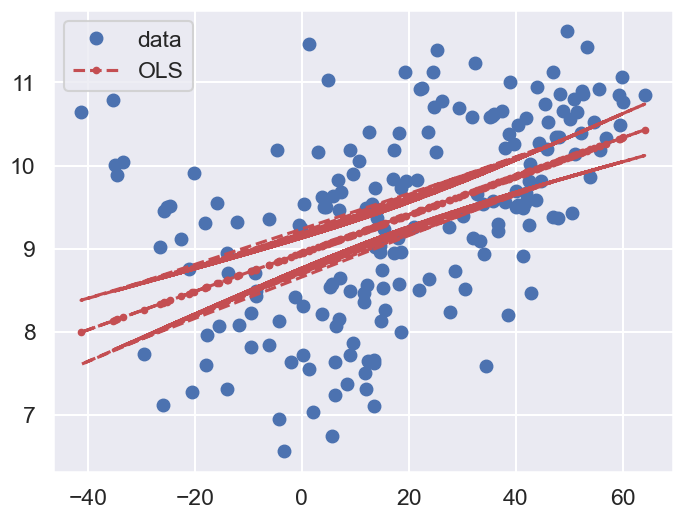

In [18]:
pred_ols = mod.get_prediction()
iv_l = pred_ols.summary_frame()["mean_ci_lower"]
iv_u = pred_ols.summary_frame()["mean_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(dffig.latitude, dffig.ln_gdp_pc, "o", label="data")
ax.plot(dffig.latitude, mod.fittedvalues, "r--.", label="OLS")
ax.plot(dffig.latitude, iv_u, "r--")
ax.plot(dffig.latitude, iv_l, "r--")
ax.legend(loc="best")

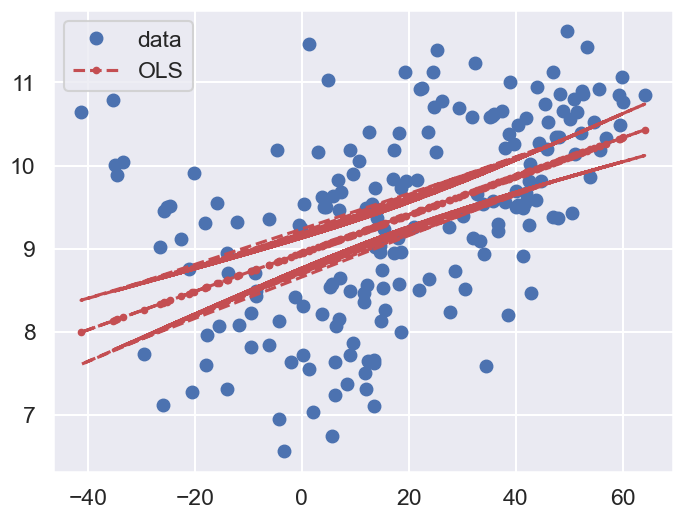

In [19]:
fig

## Simple Regression of Log[GDP pc] and Latitude accounting for WB region dummies

In [20]:
mod2 = smf.ols(formula='ln_gdp_pc ~ latitude + C(region)', data=dffig, missing='drop').fit()

In [21]:
mod2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
=======================================================================================
Model:                      OLS                     Adj. R-squared:            0.499   
Dependent Variable:         ln_gdp_pc               AIC:                       472.1345
Date:                       2023-11-08 13:32        BIC:                       498.1527
No. Observations:           191                     Log-Likelihood:            -228.07 
Df Model:                   7                       F-statistic:               28.07   
Df Residuals:               183                     Prob (F-statistic):        5.21e-26
R-squared:                  0.518                   Scale:                     0.66568 
---------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------
Intercept                                9.3610   0.1480 63.2482 0.0000  9.0690  9.6530
C(region)[T.Europe & Central Asia]       0.8050   0.2627  3.0647 0.0025  0.2868  1.3233
C(region)[T.Latin America & Caribbean ]  0.2152   0.2013  1.0691 0.2864 -0.1820  0.6125
C(region)[T.Middle East & North Africa]  0.5251   0.2650  1.9810 0.0491  0.0021  1.0480
C(region)[T.North America]               1.5880   0.5149  3.0842 0.0024  0.5721  2.6039
C(region)[T.South Asia]                 -0.6471   0.3330 -1.9436 0.0535 -1.3041  0.0098
C(region)[T.Sub-Saharan Africa ]        -1.2769   0.1915 -6.6671 0.0000 -1.6547 -0.8990
latitude                                 0.0012   0.0043  0.2736 0.7847 -0.0074  0.0097
---------------------------------------------------------------------------------------
Omnibus:                      0.984               Durbin-Watson:                  1.974
Prob(Omnibus):                0.611               Jarque-Bera (JB):               1.057
Skew:                         0.166               Prob(JB):                       0.589
Kurtosis:                     2.850               Condition No.:                  287  
=======================================================================================

"""

## Simple Regression of Log[GDP pc] and absolute latitude, accounting for WB region dummies

In [22]:
mod3 = smf.ols(formula='ln_gdp_pc ~ np.abs(latitude) + C(region)', data=dffig, missing='drop').fit()

In [23]:
mod3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
=======================================================================================
Model:                      OLS                     Adj. R-squared:            0.525   
Dependent Variable:         ln_gdp_pc               AIC:                       462.1499
Date:                       2023-11-08 13:32        BIC:                       488.1681
No. Observations:           191                     Log-Likelihood:            -223.07 
Df Model:                   7                       F-statistic:               30.98   
Df Residuals:               183                     Prob (F-statistic):        4.89e-28
R-squared:                  0.542                   Scale:                     0.63177 
---------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------
Intercept                                9.0057   0.1831 49.1737 0.0000  8.6444  9.3671
C(region)[T.Europe & Central Asia]       0.2114   0.2738  0.7722 0.4410 -0.3287  0.7515
C(region)[T.Latin America & Caribbean ]  0.2381   0.1962  1.2138 0.2264 -0.1489  0.6251
C(region)[T.Middle East & North Africa]  0.2837   0.2508  1.1311 0.2595 -0.2111  0.7785
C(region)[T.North America]               1.1674   0.5024  2.3236 0.0212  0.1762  2.1587
C(region)[T.South Asia]                 -0.7502   0.3177 -2.3615 0.0193 -1.3770 -0.1234
C(region)[T.Sub-Saharan Africa ]        -1.1585   0.1890 -6.1302 0.0000 -1.5313 -0.7856
np.abs(latitude)                         0.0211   0.0067  3.1464 0.0019  0.0079  0.0344
---------------------------------------------------------------------------------------
Omnibus:                      3.195               Durbin-Watson:                  1.875
Prob(Omnibus):                0.202               Jarque-Bera (JB):               2.943
Skew:                         0.302               Prob(JB):                       0.230
Kurtosis:                     3.069               Condition No.:                  284  
=======================================================================================

"""

## Simple Regression of Log[GDP pc] and Log[absolute latitude] accounting for WB region dummies

In [24]:
mod4 = smf.ols(formula='ln_gdp_pc ~ np.log(np.abs(latitude)) + C(region)', data=dffig, missing='drop').fit()

In [25]:
mod4.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
=======================================================================================
Model:                      OLS                     Adj. R-squared:            0.502   
Dependent Variable:         ln_gdp_pc               AIC:                       471.2747
Date:                       2023-11-08 13:32        BIC:                       497.2928
No. Observations:           191                     Log-Likelihood:            -227.64 
Df Model:                   7                       F-statistic:               28.31   
Df Residuals:               183                     Prob (F-statistic):        3.49e-26
R-squared:                  0.520                   Scale:                     0.66269 
---------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------
Intercept                                9.1968   0.2312 39.7865 0.0000  8.7407  9.6528
C(region)[T.Europe & Central Asia]       0.7575   0.2129  3.5581 0.0005  0.3375  1.1776
C(region)[T.Latin America & Caribbean ]  0.2066   0.2011  1.0273 0.3056 -0.1902  0.6033
C(region)[T.Middle East & North Africa]  0.4902   0.2506  1.9561 0.0520 -0.0042  0.9847
C(region)[T.North America]               1.5442   0.5001  3.0874 0.0023  0.5574  2.5309
C(region)[T.South Asia]                 -0.6600   0.3248 -2.0318 0.0436 -1.3009 -0.0191
C(region)[T.Sub-Saharan Africa ]        -1.2540   0.1918 -6.5368 0.0000 -1.6325 -0.8755
np.log(np.abs(latitude))                 0.0696   0.0733  0.9492 0.3438 -0.0751  0.2143
---------------------------------------------------------------------------------------
Omnibus:                      1.153               Durbin-Watson:                  1.952
Prob(Omnibus):                0.562               Jarque-Bera (JB):               1.193
Skew:                         0.183               Prob(JB):                       0.551
Kurtosis:                     2.876               Condition No.:                  29   
=======================================================================================

"""

# Producing a nice table with **stargazer**

In [26]:
url = 'https://nbviewer.org/github/mwburke/stargazer/blob/master/examples.ipynb'
IFrame(url, width=800, height=400)

## Add the estimated models to **Stargazer**

In [27]:
stargazer = Stargazer([mod, mod2, mod3, mod4])

In [28]:
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
#stargazer.dep_var_name = ''
stargazer.dependent_variable = ' Log[GDP per capita (' + str(year) + ')]'
stargazer.custom_columns(['Latitude', 'Abs(Latitude)', 'Log[Abs(Latitude)]'], [2, 1, 1])
#stargazer.show_model_numbers(False)
stargazer.rename_covariates({'latitude':'Latitude', 
                             'np.abs(latitude)':'Absolute Latitude',
                             'np.log(np.abs(latitude))':'Log[Absolute Latitude]',})
stargazer.add_line('WB Region FE', ['No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_TOP)
stargazer.covariate_order(['latitude', 'np.abs(latitude)', 'np.log(np.abs(latitude))'])
stargazer.cov_spacing = 2

In [29]:
stargazer

## To show the table
```python
HTML(stargazer.render_html())
```

In [30]:
HTML(stargazer.render_html())

## To export the table to another file

In [31]:
file_name = "table.html" #Include directory path if needed
html_file = open(pathgraphs + file_name, "w" ) #This will overwrite an existing file
html_file.write( stargazer.render_html() )
html_file.close()

In [32]:
url = pathgraphs + 'table.html'
url = 'https://smu-econ-growth.github.io/EconGrowthUG-Slides-Working-with-WDI/table.html'
IFrame(url, width=500, height=300)

# Plotting WDI data

## Many options
* Since the data is a **pandas** dataframe, we could just use its functions as [we did previously](./Intro-Data-Analysis-Pandas.ipynb)
* Use the **[seaborn](https://seaborn.pydata.org/index.html)** package
* Use the **[plotly](https://plotly.com/python/)** package
* Use the **[plotnine](https://plotnine.readthedocs.io/en/stable/)** package

# Plots with 
<center><a href="https://seaborn.pydata.org/index.html#"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/logo-wide-lightbg.svg" alt="seaborn" width=700/></a></center>

In [33]:
url = 'https://seaborn.pydata.org/examples/index.html'
IFrame(url, width=800, height=400)

Let's create a [Scatterplot with varying point sizes and hues](https://seaborn.pydata.org/examples/scatter_bubbles.html) that plots the latitude and Log[GDP per capita] of each country and uses its log-population and the WB region in the last available year as the size and hue.

## Using [`relplot`](https://seaborn.pydata.org/generated/seaborn.relplot.html#seaborn.relplot)

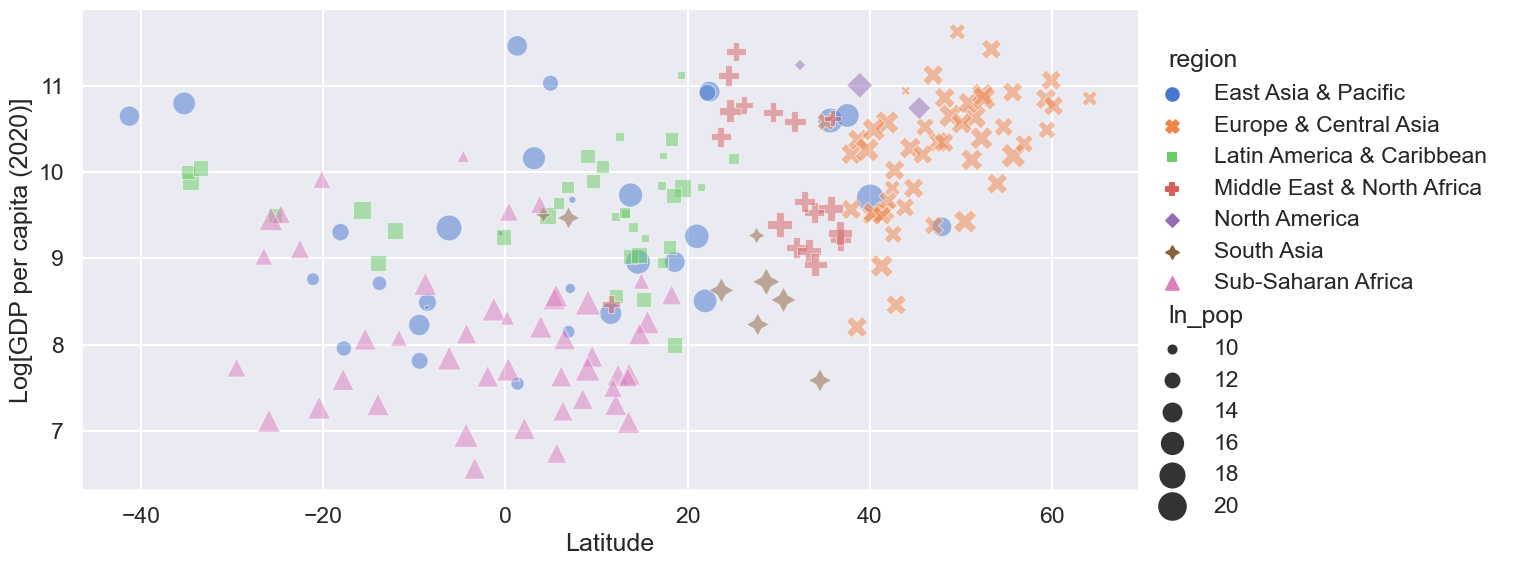

In [34]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

g = sns.relplot(x="latitude", 
                y="ln_gdp_pc", 
                data=dffig,
                hue="region",
                hue_order = dffig.region.drop_duplicates().sort_values(),
                style="region",
                style_order = dffig.region.drop_duplicates().sort_values(),
                size="ln_pop",
                sizes=(10, 400), 
                alpha=.5, 
                height=6,
                aspect=2,
                palette="muted",
               )
g.set_axis_labels('Latitude', 'Log[GDP per capita (' + str(year) + ')]')

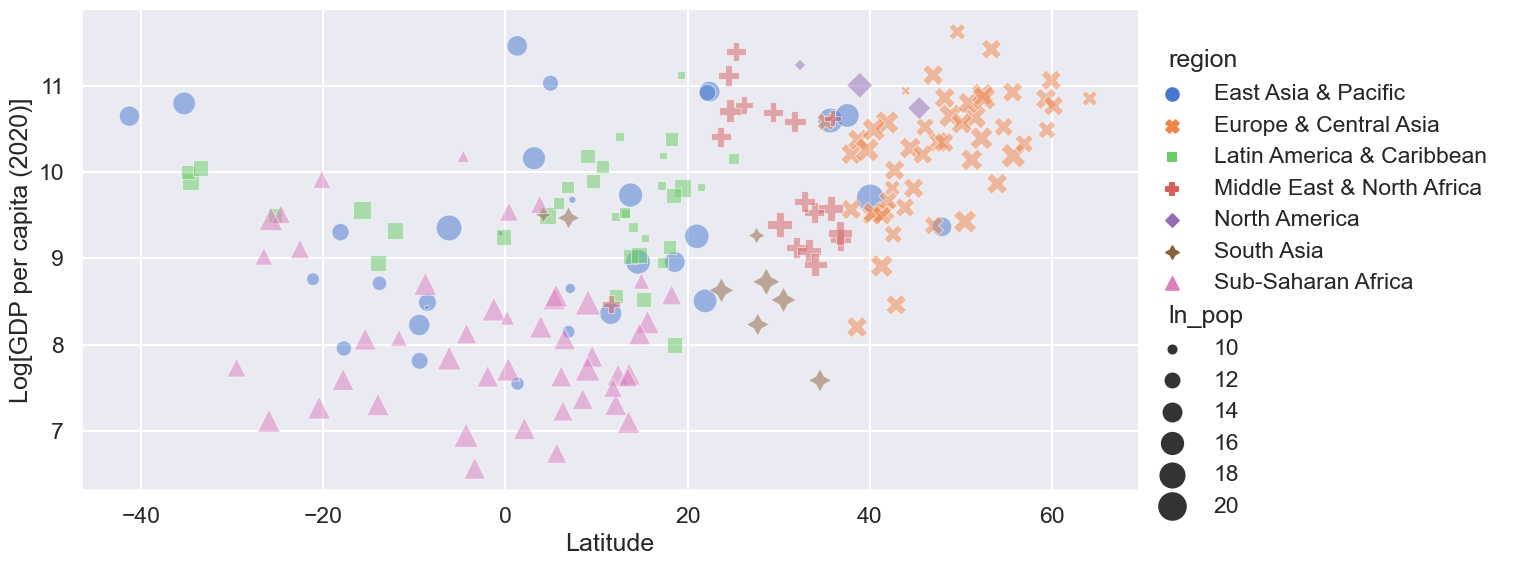

In [35]:
g.fig

# Using [`scatterplot`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)

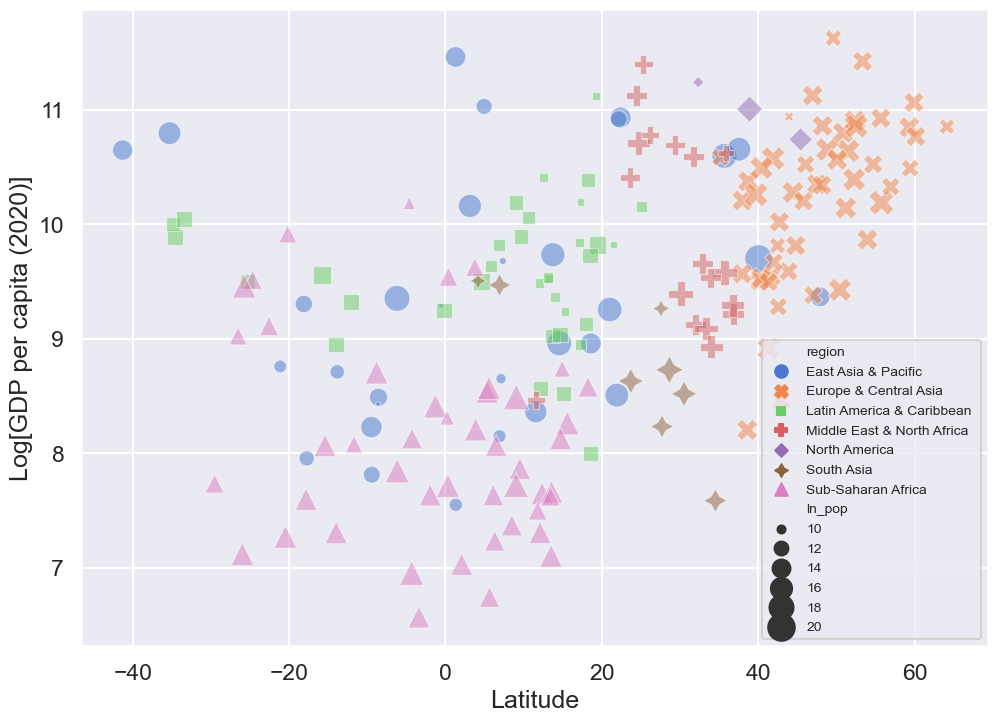

In [36]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

fig, ax = plt.subplots()
sns.scatterplot(x="latitude", 
                y="ln_gdp_pc", 
                data=dffig,
                hue="region",
                hue_order = dffig.region.drop_duplicates().sort_values(),
                style="region",
                style_order = dffig.region.drop_duplicates().sort_values(),
                size="ln_pop",
                sizes=(10, 400), 
                alpha=.5, 
                palette="muted",
                ax=ax
               )
ax.set_xlabel('Latitude')
ax.set_ylabel('Log[GDP per capita (' + str(year) + ')]')
ax.legend(fontsize=10)

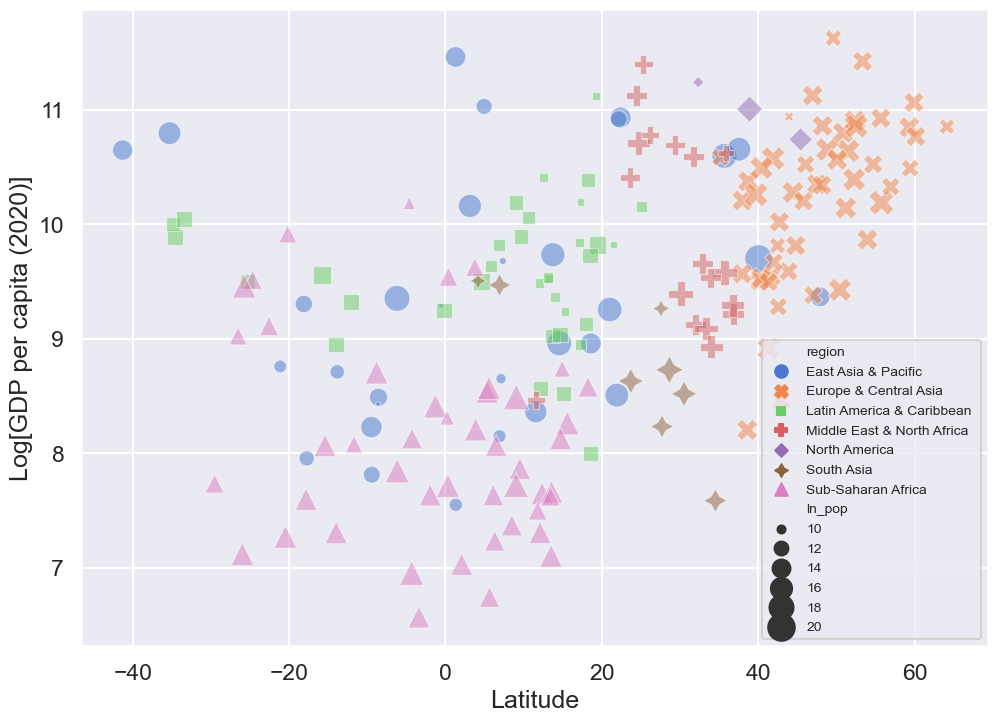

In [37]:
fig

# Based on **seaborn** we can create a useful functions that create plots for us
## E.g., scatter plots with labels, OLS regression lines, 45 degree lines, etc

In [38]:
def my_xy_plot(dfin, 
               x='SP.POP.GROW', 
               y='ln_gdp_pc', 
               labelvar='iso3c', 
               dx=0.006125, 
               dy=0.006125, 
               xlogscale=False, 
               ylogscale=False,
               xlabel='Growth Rate of Population', 
               ylabel='Log[Income per capita in ' +  str(year) + ']',
               labels=False,
               xpct = False,
               ypct = False,
               OLS=False,
               OLSlinelabel='OLS',
               ssline=False,
               sslinelabel='45 Degree Line',
               filename='income-pop-growth.pdf',
               hue='region',
               hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                          'Latin America & Caribbean ', 'Middle East & North Africa',
                          'North America', 'South Asia', 'Sub-Saharan Africa '],
               style='incomeLevel', 
               style_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
               palette=None,
               size=None,
               sizes=None,
               legend_fontsize=10,
               label_font_size=12,
               save=True):
    '''
    Plot the association between x and var in dataframe using labelvar for labels.
    '''
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_context("talk")
    df = dfin.copy()
    df = df.dropna(subset=[x, y]).reset_index(drop=True)
    # Plot
    k = 0
    fig, ax = plt.subplots()
    sns.scatterplot(x=x, y=y, data=df, ax=ax, 
                    hue=hue,
                    hue_order=hue_order,
                    #hue='incomeLevel',
                    #hue_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                    #hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                    #           'Latin America & Caribbean ', 'Middle East & North Africa',
                    #           'North America', 'South Asia', 'Sub-Saharan Africa '],
                    alpha=1, 
                    style=style, 
                    style_order=style_order,
                    palette=palette,
                    size=size,
                    sizes=sizes,
                    #palette=sns.color_palette("Blues_r", df[hue].unique().shape[0]+6)[:df[hue].unique().shape[0]*2:2],
                )
    if OLS:
        sns.regplot(x=x, y=y, data=df, ax=ax, label=OLSlinelabel, scatter=False)
    if ssline:
        ax.plot([df[x].min()*.99, df[x].max()*1.01], [df[x].min()*.99, df[x].max()*1.01], c='r', label=sslinelabel)
    if labels:
        movex = df[x].mean() * dx
        movey = df[y].mean() * dy
        for line in range(0,df.shape[0]):
            ax.text(df[x][line]+movex, df[y][line]+movey, df[labelvar][line], horizontalalignment='left', fontsize=label_font_size, color='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xpct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        xticks = mtick.FormatStrFormatter(fmt)
        ax.xaxis.set_major_formatter(xticks)
    if ypct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        yticks = mtick.FormatStrFormatter(fmt)
        ax.yaxis.set_major_formatter(yticks)
    if ylogscale:
        ax.set(yscale="log")
    if xlogscale:
        ax.set(xscale="log")
    handles, labels = ax.get_legend_handles_labels()
    handles = np.array(handles)
    labels = np.array(labels)
    handles = list(handles[(labels!=hue) & (labels!=style) & (labels!=size)])
    labels = list(labels[(labels!=hue) & (labels!=style) & (labels!=size)])
    ax.legend(handles=handles, labels=labels, fontsize=legend_fontsize)
    if save:
        plt.savefig(pathgraphs + filename, dpi=300, bbox_inches='tight')
    return fig

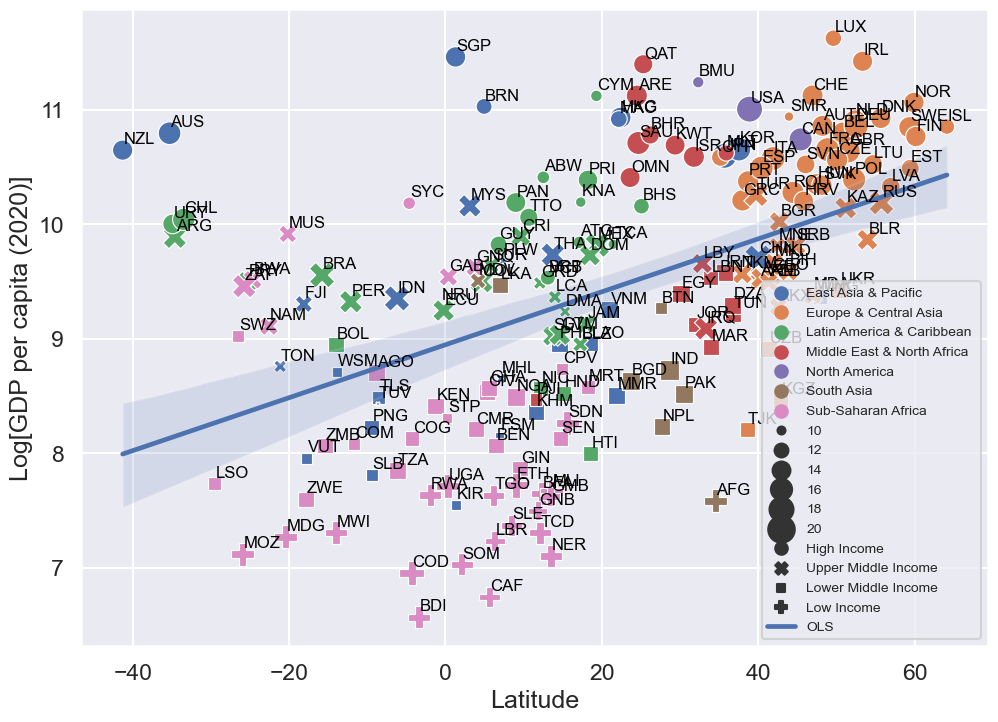

In [39]:
g = my_xy_plot(dffig, 
               x='latitude', 
               y='ln_gdp_pc', 
               xlabel='Latitude', 
               ylabel='Log[GDP per capita (' + str(year) +')]', 
               OLS=True, 
               labels=True, 
               size="ln_pop", 
               sizes=(10, 400), 
               filename='ln-gdp-pc-latitude.pdf')

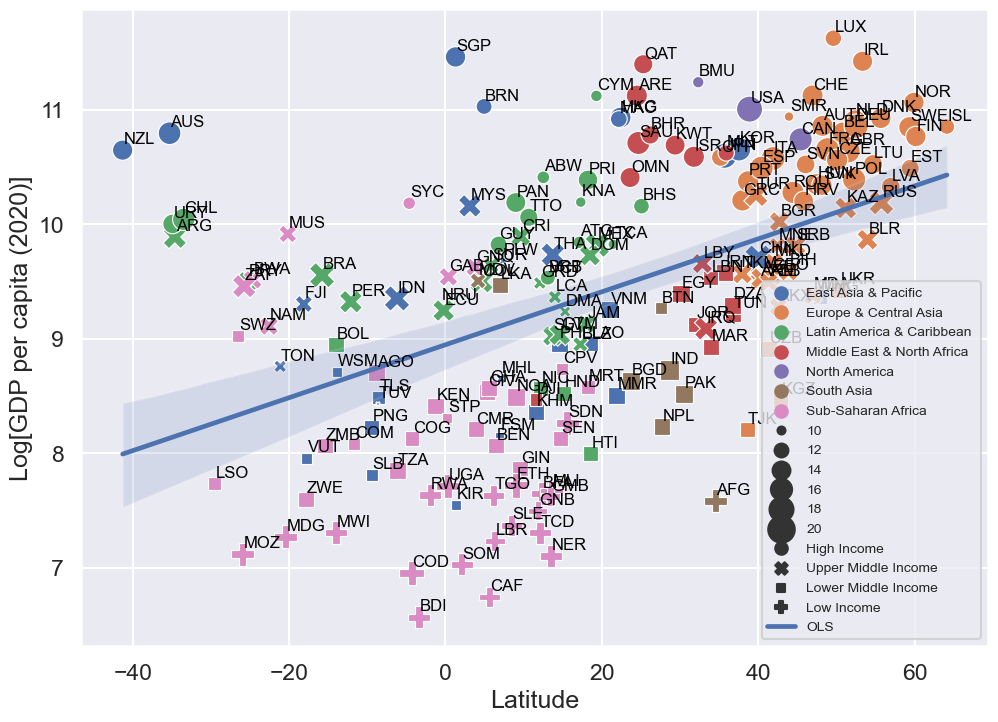

In [40]:
g

## Plot the evolution of variables across time by groups

In [41]:
def my_xy_line_plot(dfin, 
                    x='year', 
                    y='ln_gdp_pc', 
                    labelvar='iso3c', 
                    dx=0.006125, 
                    dy=0.006125, 
                    xlogscale=False, 
                    ylogscale=False,
                    xlabel='Growth Rate of Population', 
                    ylabel='Log[Income per capita in ' +  str(year) + ']',
                    labels=False,
                    xpct = False,
                    ypct = False,
                    OLS=False,
                    OLSlinelabel='OLS',
                    ssline=False,
                    sslinelabel='45 Degree Line',
                    filename='income-pop-growth.pdf',
                    hue='region',
                    hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                               'Latin America & Caribbean ', 'Middle East & North Africa',
                               'North America', 'South Asia', 'Sub-Saharan Africa '],
                    style='incomeLevel', 
                    style_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                    palette=None,
                    legend_fontsize=10,
                    label_fontsize=12,
                    loc=None,
                    save=True):
    '''
    Plot the association between x and var in dataframe using labelvar for labels. 
    '''
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_context("talk")
    df = dfin.copy()
    df = df.dropna(subset=[x, y]).reset_index(drop=True)
    # Plot
    k = 0
    fig, ax = plt.subplots()
    sns.lineplot(x=x, y=y, data=df, ax=ax, 
                    hue=hue,
                    hue_order=hue_order,
                    alpha=1, 
                    style=style, 
                    style_order=style_order,
                    palette=palette,
                )
    if OLS:
        sns.regplot(x=x, y=y, data=df, ax=ax, label=OLSlinelabel, scatter=False)
    if ssline:
        ax.plot([df[x].min()*.99, df[x].max()*1.01], [df[x].min()*.99, df[x].max()*1.01], c='r', label=sslinelabel)
    if labels:
        movex = df[x].mean() * dx
        movey = df[y].mean() * dy
        for line in range(0,df.shape[0]):
            ax.text(df[x][line]+movex, df[y][line]+movey, df[labelvar][line], horizontalalignment='left', fontsize=label_fontsize, color='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xpct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        xticks = mtick.FormatStrFormatter(fmt)
        ax.xaxis.set_major_formatter(xticks)
    if ypct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        yticks = mtick.FormatStrFormatter(fmt)
        ax.yaxis.set_major_formatter(yticks)
    if ylogscale:
        ax.set(yscale="log")
    if xlogscale:
        ax.set(xscale="log")
    handles, labels = ax.get_legend_handles_labels()
    handles = np.array(handles)
    labels = np.array(labels)
    handles = list(handles[(labels!='region') & (labels!='incomeLevel')])
    labels = list(labels[(labels!='region') & (labels!='incomeLevel')])
    ax.legend(handles=handles, labels=labels, fontsize=legend_fontsize, loc=loc)
    if save:
        plt.savefig(pathgraphs + filename, dpi=300, bbox_inches='tight')
    return fig

## Log[GDP per capita across the world] by WB Income Groups

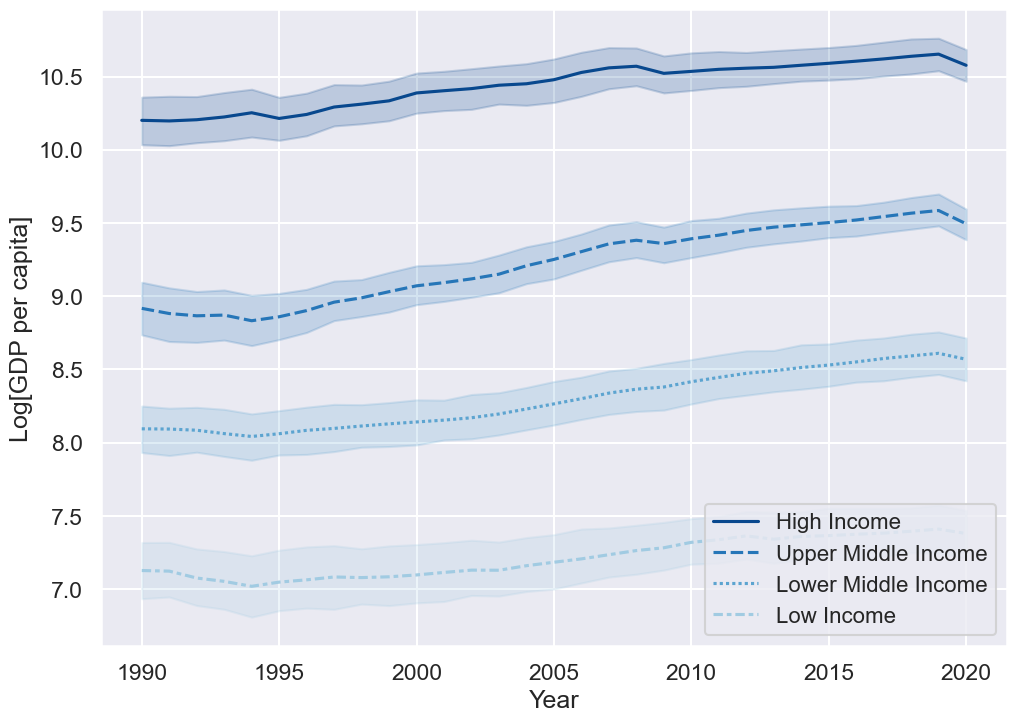

In [42]:
palette=sns.color_palette("Blues_r", wdi['incomeLevel'].unique().shape[0]+6)[:wdi['incomeLevel'].unique().shape[0]*2:2]
fig = my_xy_line_plot(wdi, 
                x='year', 
                y='ln_gdp_pc', 
                xlabel='Year',
                ylabel='Log[GDP per capita]',
                filename='ln-gdp-pc-income-groups-TS.pdf',
                hue='incomeLevel',
                hue_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                palette=palette,
                OLS=False, 
                labels=False,
                legend_fontsize=16,
                loc='lower right',
                save=True)

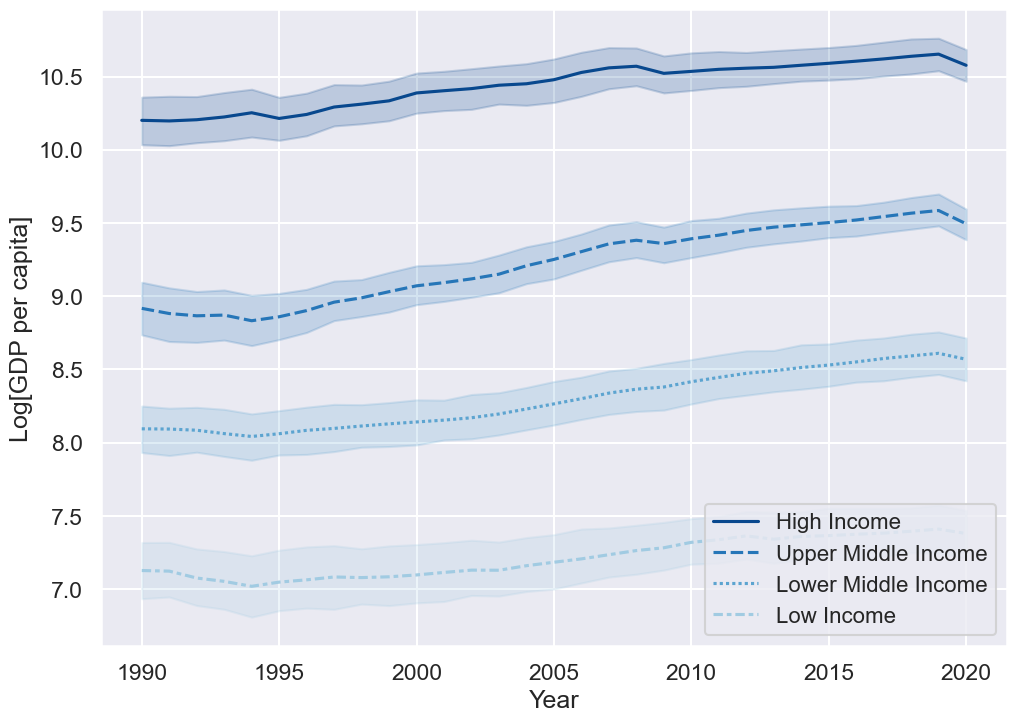

In [43]:
fig

## GDP per capita across the world by WB Regions

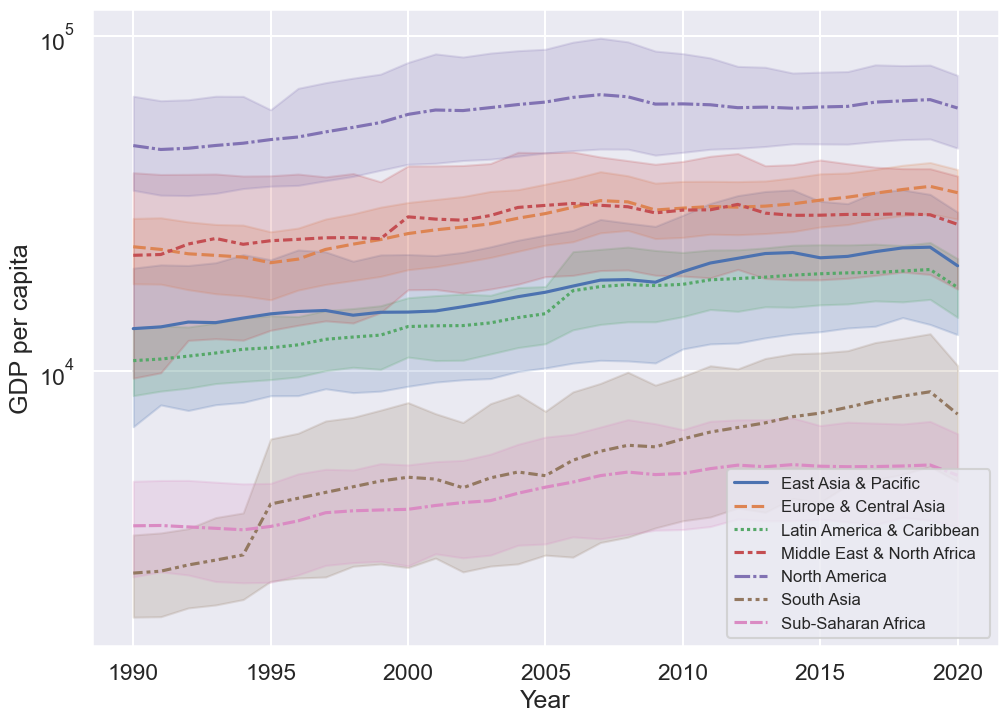

In [44]:
#palette=sns.color_palette("Blues_r", wdi['region'].unique().shape[0]+6)[:wdi['region'].unique().shape[0]*2:2]
fig = my_xy_line_plot(wdi, 
                      x='year', 
                      y='gdp_pc', 
                      xlabel='Year',
                      ylabel='GDP per capita',
                      ylogscale=True,
                      filename='ln-gdp-pc-regions-TS.pdf',
                      style='region',
                      style_order=['East Asia & Pacific', 'Europe & Central Asia',
                                   'Latin America & Caribbean ', 'Middle East & North Africa',
                                   'North America', 'South Asia', 'Sub-Saharan Africa '],
                      #palette=palette,
                      OLS=False, 
                      labels=False,
                      legend_fontsize=12,
                      loc='lower right',
                      save=True)

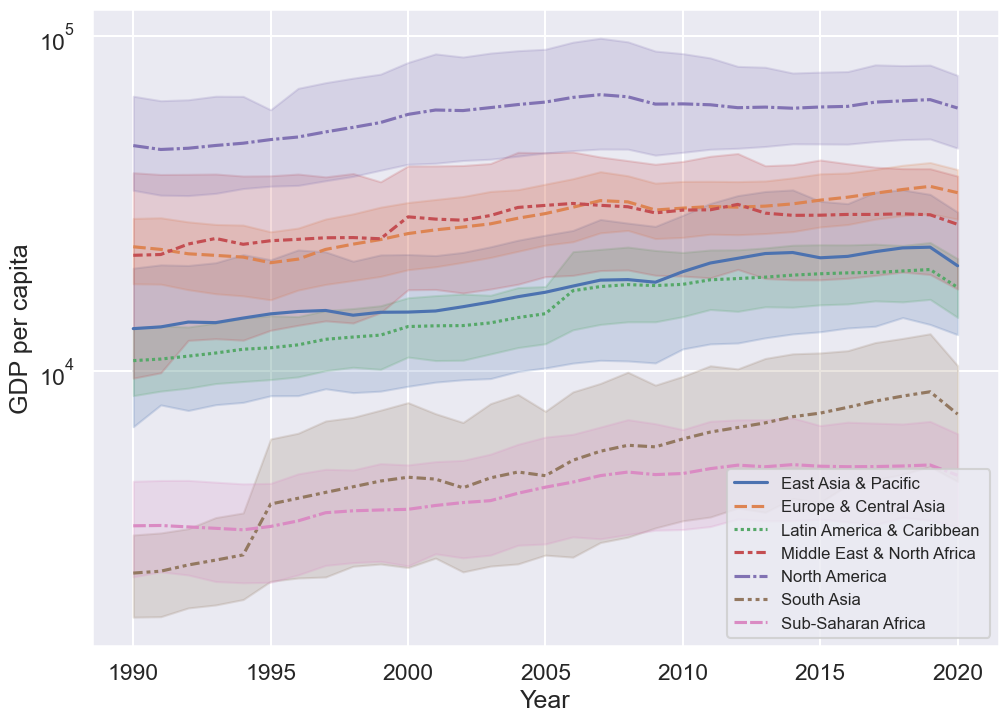

In [45]:
fig

# Plots with 
<center><a href="https://plotly.com/python/"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/plot_ly-ar21.svg" alt="plotly express" width=700/></a></center>

In [46]:
url = 'https://plotly.com/python/'
IFrame(url, width=800, height=400)

## Let's [select symbols to plot](https://plotly.com/python/marker-style/) so it looks like the previous ones and also to improve visibility

In [47]:
symbols = ['circle', 'x', 'square', 'cross', 'diamond', 'star-diamond', 'triangle-up']
fig = px.scatter(dffig,
                 x="latitude", 
                 y="ln_gdp_pc", 
                 color='region',
                 symbol='region',
                 symbol_sequence=symbols,
                 hover_name='name',
                 hover_data=['iso3c', 'ln_pop', 'gdp_pc'],
                 size='ln_pop',
                 size_max=15,
                 trendline="ols",
                 trendline_scope="overall",
                 trendline_color_override="black",
                 labels={
                     "latitude": "Latitude",
                     "ln_gdp_pc": "Log[GDP per capita (" + str(year) + ")]",
                     "gdp_pc": "GDP per capita (" + str(year) + ")",
                     "region": "WB Region"
                 },
                 opacity=0.75,
                 height=800,
                )

In [48]:
fig.show()

# Change marker borders

In [49]:
fig.update_traces(marker=dict(#size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

In [50]:
fig.show()

# Increase width of trend line

In [51]:
tr_line=[]
for  k, trace  in enumerate(fig.data):
        if trace.mode is not None and trace.mode == 'lines':
            tr_line.append(k)
print(tr_line)
for id in tr_line:
    fig.data[id].update(line_width=3)

[7]


In [52]:
fig.show()

# Change legend position

In [53]:
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.25,
    xanchor="left",
    x=0.9
))

In [54]:
fig.show()

# To save the figure use in your desired format
```python
fig.write_image(pathgraphs + "fig1.pdf")
fig.write_image(pathgraphs + "fig1.png")
fig.write_image(pathgraphs + "fig1.jpg")
```

In [55]:
fig.write_image(pathgraphs + "ln-gdp-pc-latitude-plotly.pdf", height=1000, width=1500, scale=4)

## We can access the results of the regression in **plotly express**

In [56]:
results = px.get_trendline_results(fig)
results.px_fit_results.iloc[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     57.94
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           1.25e-12
Time:                        13:33:22   Log-Likelihood:                -272.18
No. Observations:                 191   AIC:                             548.4
Df Residuals:                     189   BIC:                             554.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9466      0.092     97.085      0.000       8.765       9.128
x1             0.0231      0.003      7.612      0.000       0.017       0.029
==============================================================================
Omnibus:                        0.470   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.791   Jarque-Bera (JB):                0.604
Skew:                          -0.010   Prob(JB):                        0.739
Kurtosis:                       2.725   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Maps with
<center><a href="https://seaborn.pydata.org/index.html#"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/logo-wide-lightbg.svg" alt="seaborn" width=700/></a></center>

# To create maps we need to obtain *geographical information*

There are various types of data in **Geographic Information Systems (GIS)**

* Location of cities, resources, etc. (point data)

* Shape of rivers, borders, countries, etc. (shape data)

* Numerical data for locations (elevation, temperature, number of people)

## Download Country boundary data from [Natural Earth](http://www.naturalearthdata.com/)

In [57]:
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36', 'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8'}

url = 'https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip'
r = requests.get(url, headers=headers)
countries = gp.read_file(io.BytesIO(r.content))

In [58]:
countries.head()

featurecla  scalerank  LABELRANK SOVEREIGNT SOV_A3  ADM0_DIF  LEVEL               TYPE TLC      ADMIN  ... FCLASS_TR  FCLASS_ID FCLASS_PL FCLASS_GR  FCLASS_IT FCLASS_NL  \
0  Admin-0 country          0          2  Indonesia    IDN         0      2  Sovereign country   1  Indonesia  ...      None       None      None      None       None      None   
1  Admin-0 country          0          3   Malaysia    MYS         0      2  Sovereign country   1   Malaysia  ...      None       None      None      None       None      None   
2  Admin-0 country          0          2      Chile    CHL         0      2  Sovereign country   1      Chile  ...      None       None      None      None       None      None   
3  Admin-0 country          0          3    Bolivia    BOL         0      2  Sovereign country   1    Bolivia  ...      None       None      None      None       None      None   
4  Admin-0 country          0          2       Peru    PER         0      2  Sovereign country   1       Peru  ...      None       None      None      None       None      None   

  FCLASS_SE  FCLASS_BD FCLASS_UA                                           geometry  
0      None       None      None  MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...  
1      None       None      None  MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...  
2      None       None      None  MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...  
3      None       None      None  POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...  
4      None       None      None  MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...  

[5 rows x 169 columns]

## The boundary file is a **geopandas** dataframe

Text(0.5, 1.0, 'WGS84 (lat/lon)')

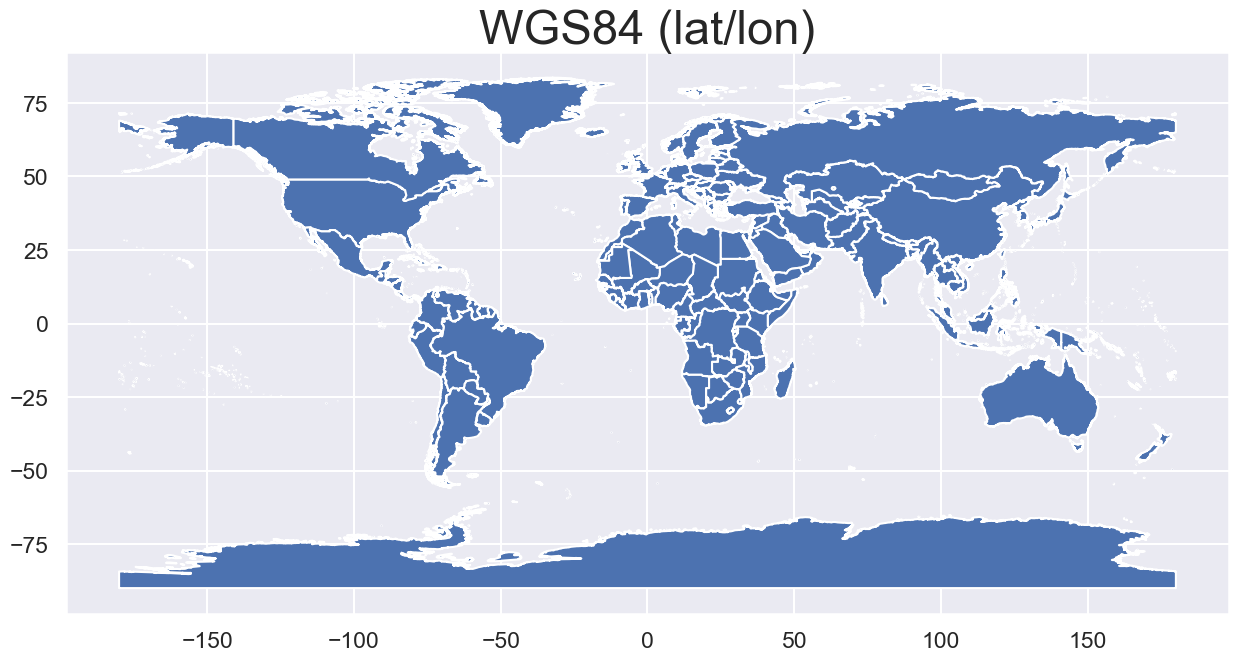

In [59]:
fig, ax = plt.subplots(figsize=(15,10))
countries.plot(ax=ax)
ax.set_title("WGS84 (lat/lon)", fontdict={'fontsize':34})

## Merge with other data and plot

In [60]:
dffig2 = countries.merge(dffig, left_on='ADM0_A3', right_on='iso3c')

Text(0.5, 1.0, 'WGS84 (lat/lon)')

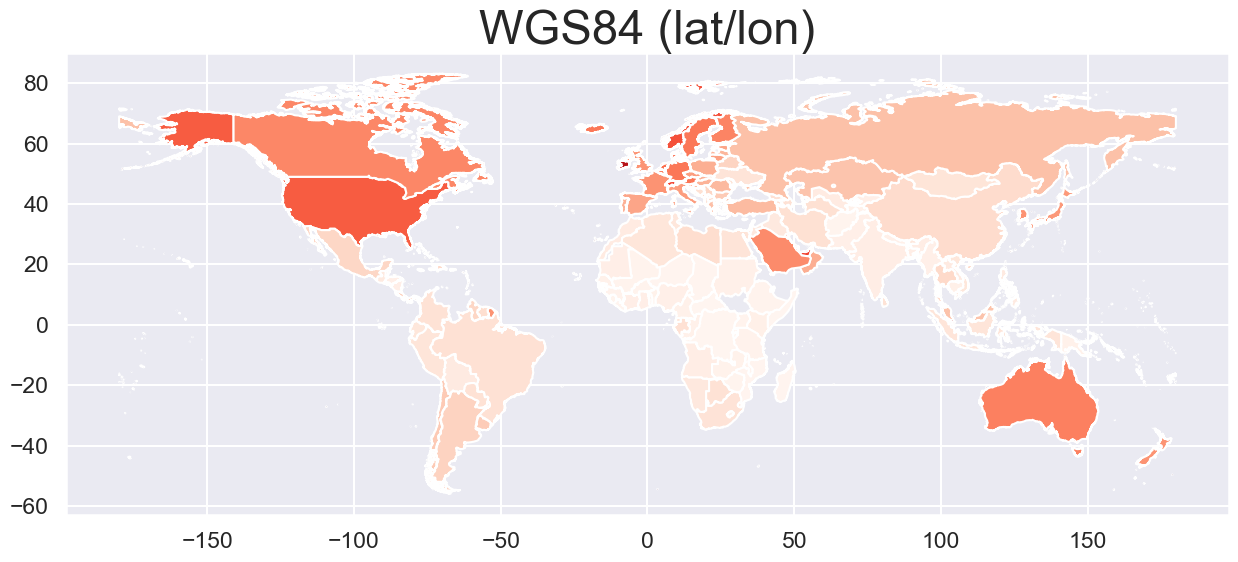

In [61]:
fig, ax = plt.subplots(figsize=(15,10))
dffig2.plot(column='gdp_pc', ax=ax, cmap='Reds')
ax.set_title("WGS84 (lat/lon)", fontdict={'fontsize':34})

# Maps with [geoplot](https://residentmario.github.io/geoplot/)

In [62]:
url = 'https://residentmario.github.io/geoplot/'
IFrame(url, width=800, height=400)

# Plot Countries

<GeoAxesSubplot:>

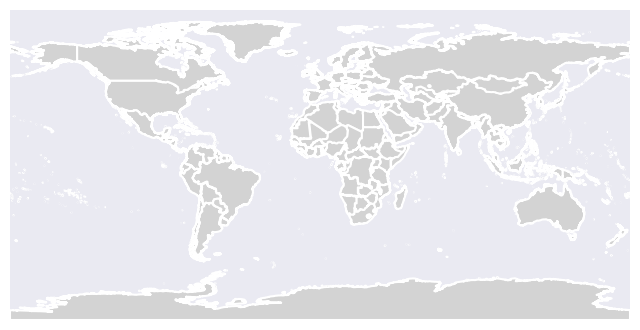

In [63]:
gplt.polyplot(
    countries, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
    edgecolor='white', facecolor='lightgray',
    rasterized=True,
    extent=[-180, -90, 180, 90],
)

# Plot Data

<GeoAxesSubplot:>

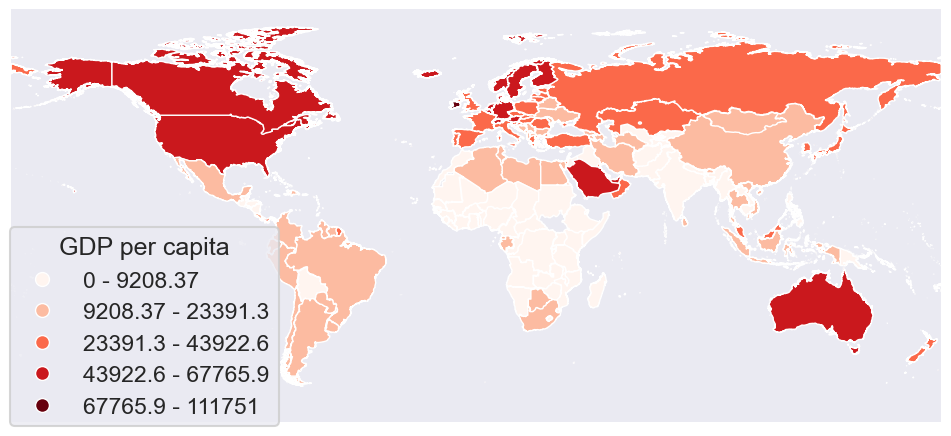

In [64]:
gplt.choropleth(dffig2, hue='gdp_pc', 
                projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
                edgecolor='white', 
                linewidth=1,
                cmap='Reds', legend=True,
                scheme='FisherJenks',
                legend_kwargs={'bbox_to_anchor':(0.3, 0.5),
                               'frameon': True,
                               'title':'GDP per capita',
                              },
                figsize=(12,8),
                rasterized=True,
               )

# Data and Borders

<GeoAxesSubplot:>

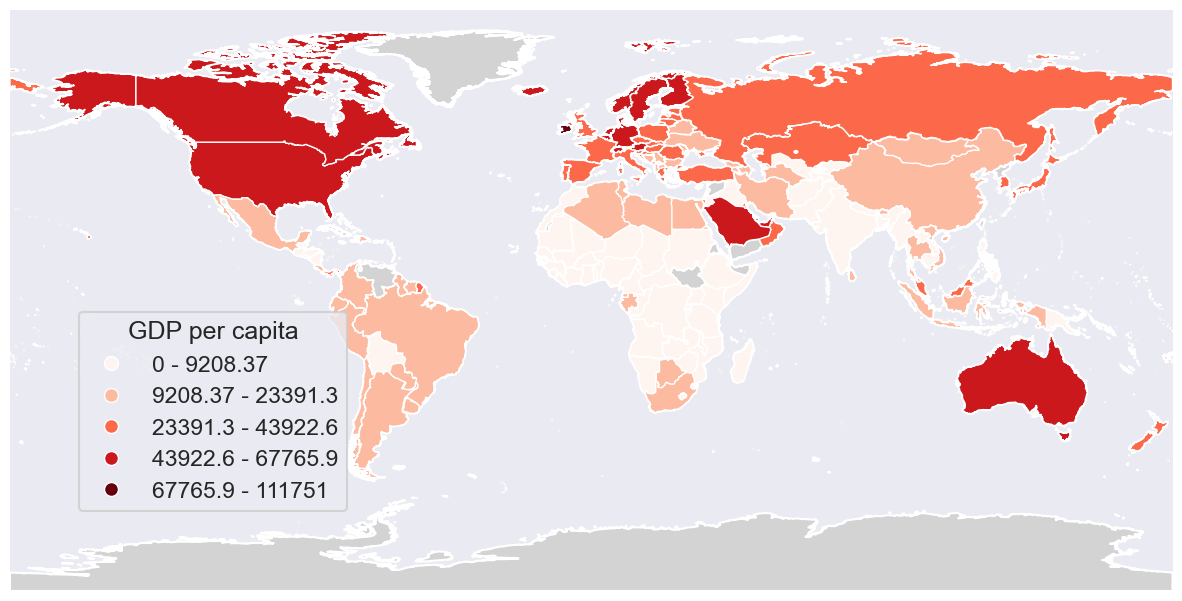

In [65]:
ax = gplt.choropleth(dffig2, hue='gdp_pc', projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
                     edgecolor='white', linewidth=1,
                     cmap='Reds', legend=True,
                     scheme='FisherJenks',
                     legend_kwargs={'bbox_to_anchor':(0.3, 0.5),
                                    'frameon': True,
                                    'title':'GDP per capita',
                                   },
                     figsize=(15,10),
                     rasterized=True,
                    )
gplt.polyplot(countries, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
              edgecolor='white', facecolor='lightgray',
              ax=ax,
              rasterized=True,
              extent=[-180, -90, 180, 90],
             )

# Use a nice function

In [66]:
# Functions for plotting
def center_wrap(text, cwidth=32, **kw):
    '''Center Text (to be used in legend)'''
    lines = text
    #lines = textwrap.wrap(text, **kw)
    return "\n".join(line.center(cwidth) for line in lines)

def MyChloropleth(mydf, myfile='fig', myvar='gdp_pc',
                  mylegend='GDP per capita',
                  k=5,
                  extent=[-180, -90, 180, 90],
                  bbox_to_anchor=(0.2, 0.5),
                  edgecolor='white', facecolor='lightgray',
                  scheme='FisherJenks',
                  save=True,
                  percent=False,
                  rn=0,
                  **kwargs):
    # Chloropleth
    # Color scheme
    if scheme=='EqualInterval':
        scheme = mc.EqualInterval(mydf[myvar], k=k)
    elif scheme=='Quantiles':
        scheme = mc.Quantiles(mydf[myvar], k=k)
    elif scheme=='BoxPlot':
        scheme = mc.BoxPlot(mydf[myvar], k=k)
    elif scheme=='FisherJenks':
        scheme = mc.FisherJenks(mydf[myvar], k=k)
    elif scheme=='FisherJenksSampled':
        scheme = mc.FisherJenksSampled(mydf[myvar], k=k)
    elif scheme=='HeadTailBreaks':
        scheme = mc.HeadTailBreaks(mydf[myvar], k=k)
    elif scheme=='JenksCaspall':
        scheme = mc.JenksCaspall(mydf[myvar], k=k)
    elif scheme=='JenksCaspallForced':
        scheme = mc.JenksCaspallForced(mydf[myvar], k=k)
    elif scheme=='JenksCaspallSampled':
        scheme = mc.JenksCaspallSampled(mydf[myvar], k=k)
    elif scheme=='KClassifiers':
        scheme = mc.KClassifiers(mydf[myvar], k=k)
    # Format legend
    upper_bounds = scheme.bins
    # get and format all bounds
    bounds = []
    for index, upper_bound in enumerate(upper_bounds):
        if index == 0:
            lower_bound = mydf[myvar].min()
        else:
            lower_bound = upper_bounds[index-1]
        # format the numerical legend here
        if percent:
            bound = f'{lower_bound:.{rn}%} - {upper_bound:.{rn}%}'.format(width=rn)
        else:
            bound = f'{float(lower_bound):,.{rn}f} - {float(upper_bound):,.{rn}f}'.format(width=rn)
        bounds.append(bound)
    legend_labels = bounds
    #Plot
    ax = gplt.choropleth(
        mydf, hue=myvar, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', linewidth=1,
        cmap='Reds', legend=True,
        scheme=scheme,
        legend_kwargs={'bbox_to_anchor': bbox_to_anchor,
                       'frameon': True,
                       'title':mylegend,
                       },
        legend_labels = legend_labels,
        figsize=(24, 16),
        rasterized=True,
    )
    gplt.polyplot(
        countries, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor=edgecolor, facecolor=facecolor,
        ax=ax,
        rasterized=True,
        extent=extent,
    )
    if save:
        plt.savefig(pathgraphs + myfile + '.pdf', dpi=300, bbox_inches='tight')
        plt.savefig(pathgraphs + myfile + '.png', dpi=300, bbox_inches='tight')
    pass

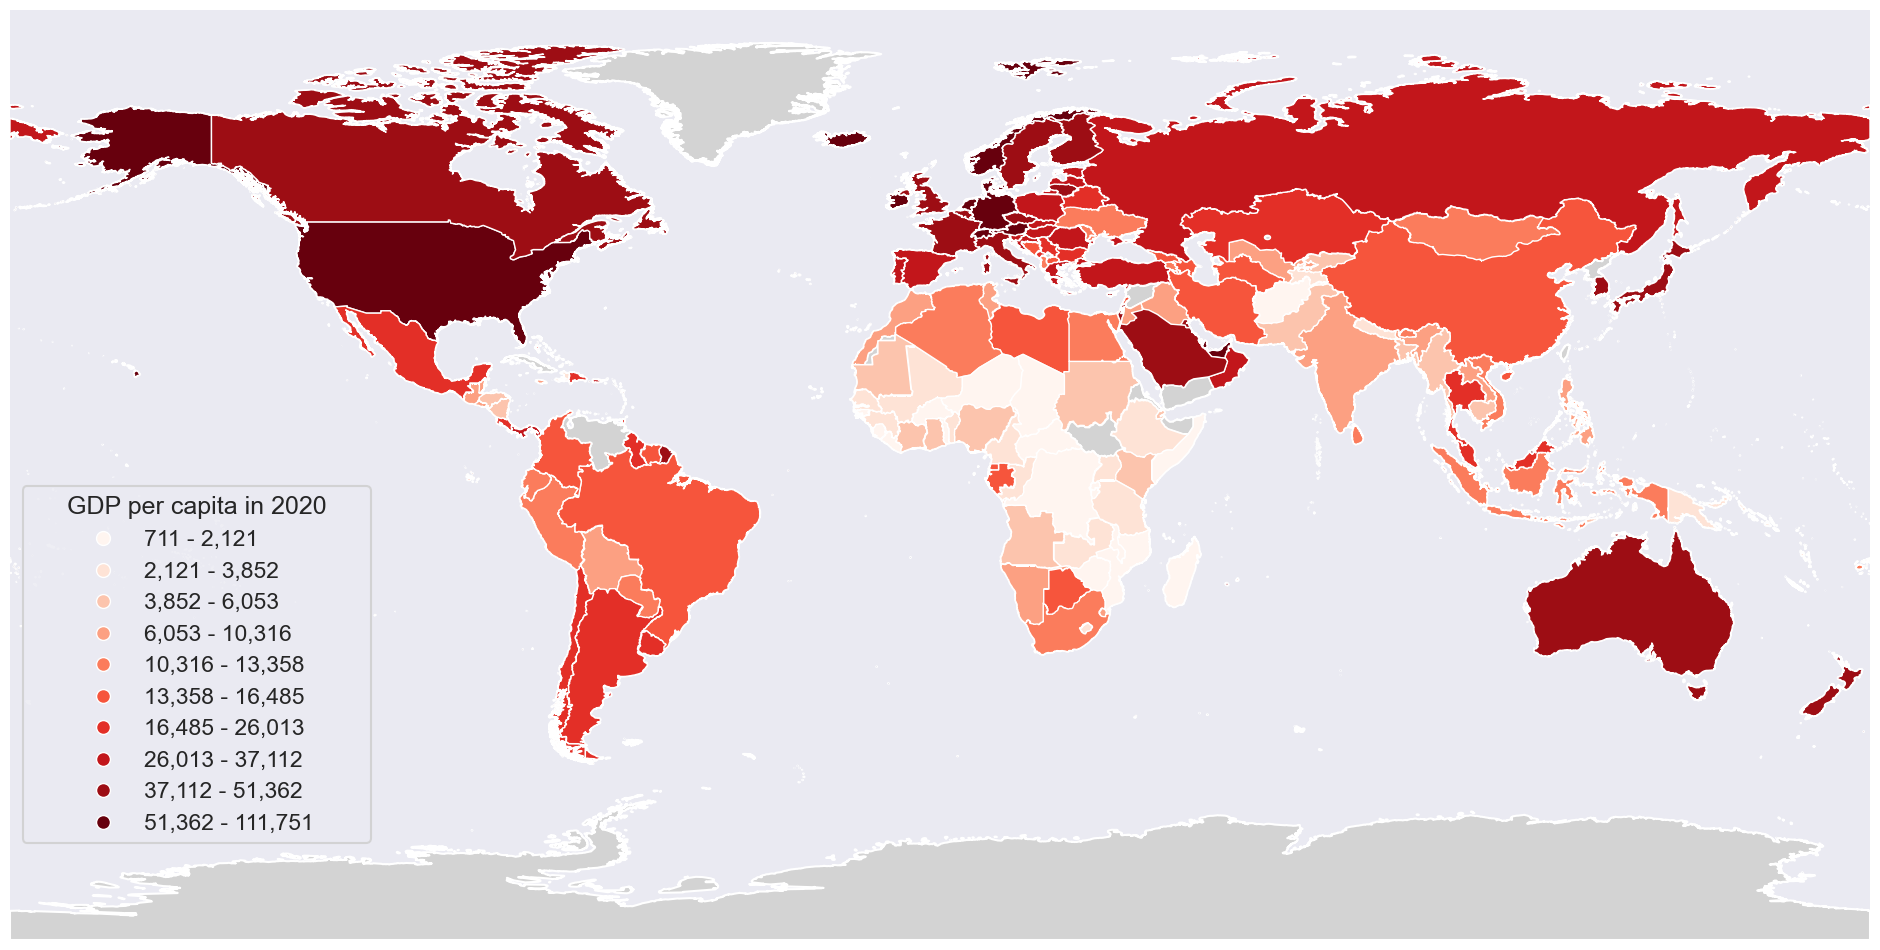

In [67]:
mylegend = center_wrap(["GDP per capita in " + str(year)], cwidth=32, width=32)
MyChloropleth(dffig2, myfile='fig-gdp-pc-' + str(year), myvar='gdp_pc', mylegend=mylegend, k=10, scheme='Quantiles', save=True)

# Quick and Easy Maps with
<center><a href="https://plotly.com/python/"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/plot_ly-ar21.svg" alt="plotly express" width=700/></a></center>

In [68]:
url = 'https://plotly.com/python/maps/'
IFrame(url, width=800, height=400)

# Map using classes (similar to **geoplot**)

## Choose a classifier and classify the data

In [69]:
scheme = mc.Quantiles(dffig2['gdp_pc'], k=5)
classifier = mc.Quantiles.make(k=5, rolling=True)
dffig2['gdp_pc_q'] = classifier(dffig2['gdp_pc'])
dffig2['gdp_pc_qc'] = dffig2['gdp_pc_q'].apply(lambda x: scheme.get_legend_classes()[x].replace('[   ', '[').replace('( ', '('))

In [85]:
fig = px.choropleth(dffig2.sort_values('gdp_pc_q', ascending=True), 
                    locations="iso3c",
                    color="gdp_pc_qc",
                    hover_name='name',
                    hover_data=['iso3c', 'ln_pop'],
                    labels={
                        "gdp_pc_qc": "GDP per capita (" + str(year) + ")",
                    },
                    color_discrete_sequence=px.colors.sequential.Reds,
                    height=600, 
                    width=1000,
                   )
# Change legend position
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.15,
    xanchor="left",
    x=0.05
))

In [71]:
fig.show()

In [72]:
fig = px.choropleth(dffig2.sort_values('gdp_pc_q', ascending=True), 
                    locations="iso3c",
                    color="gdp_pc_qc",
                    hover_name='name',
                    hover_data=['iso3c', 'gdp_pc' ,'ln_pop'],
                    labels={
                        "gdp_pc_qc": "GDP per capita (" + str(year) + ")",
                        "gdp_pc": "GDP per capita (" + str(year) + ")",
                        'iso3c':'ISO code',
                        "ln_pop": "Log[Population (" + str(year) + ")]",
                    },
                    color_discrete_sequence=px.colors.sequential.Blues,
                    height=600, 
                    width=1000,
                   )
# Change legend position
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.15,
    xanchor="left",
    x=0.05
))

In [73]:
fig.show()

In [74]:
fig = px.choropleth(dffig, 
                    locations="iso3c",
                    color="ln_gdp_pc",
                    hover_name='name',
                    hover_data=['iso3c', 'ln_pop'],
                    labels={
                        "ln_gdp_pc": "Log[GDP per capita (" + str(year) + ")]",
                    },
                    #color_continuous_scale=px.colors.sequential.Plasma,
                    color_continuous_scale="Reds",
                    height=600, 
                    width=1100,
                   )

In [75]:
fig.show()

In [76]:
fig.update_layout(coloraxis_colorbar=dict(
    orientation = 'h',
    yanchor="bottom", 
    xanchor="left", 
    y=-.2,
    x=0,
))
fig.update_coloraxes(colorbar_title_side='top')

In [77]:
fig.show()

In [78]:
# Change legend position
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="center",
    x=0.01,
    orientation='h',
))

In [79]:
fig.show()

In [80]:
fig = go.Figure(data=go.Choropleth(
    locations = dffig['iso3c'],
    z = dffig['gdp_pc'],
    text = dffig['name'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '$',
    colorbar_title = 'GDP pc',
    )                  
)
fig.update_layout(
    autosize=False,
    width=800,
    height=400,
    margin=dict(
        l=5,
        r=5,
        b=10,
        t=10,
        pad=1
    ),
    paper_bgcolor="LightSteelBlue",
)

In [81]:
fig.show()

In [82]:
fig = go.Figure(data=go.Choropleth(
    locations = dffig['iso3c'],
    z = dffig['gdp_pc'],
    text = dffig['name'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '$',
    colorbar_title = 'GDP per capita',
    )                  
)
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=1,
        pad=.1
    ),
    paper_bgcolor="LightSteelBlue",
)
# Change legend position
cb = fig.data[0].colorbar
cb.orientation = 'h'
cb.yanchor = 'bottom'
cb.xanchor = 'center'
cb.y = .1
cb.title.side = 'top'

In [83]:
fig.show()

# <center>Exercises</center>

<div class="alert alert-block alert-warning">
    <b>Exercise 1:</b> Get WDI data on <b>patent applications by residents and non-residents in each country</b>. Create a new variable that shows the total patents for each country.
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 2:</b> Using the <code>my_xy_plot</code> function plot the relation between <b>GDP per capita</b> and <b>total patents</b> in the years 1990, 1995, 2000, 2010, 2020.
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 3:</b> Using the <code>my_xy_line_plot</code> function plot the evolution of <b>GDP per capita</b> and <b>total patents</b> by income groups and regions (separate figures).
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 4:</b> Plot the relation between patenting activity by <b>residents and non-residents</b> in the year 2015. Make sure to show the 45 degree line so you can see how similar they are.
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 5:</b> Create a static and a dynamic map for patenting activity in the year 2015 across the world. 
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 6:</b> Explore the relation between economic development as measured by Log[GDP per capita] and patenting activity. Show the relation for residents, non-residents, and total, all in one nice looking table. Also, produce a few nice looking figures.
</div>

Notebook written by [Ömer Özak](http://omerozak.com) for his students in Economics at [Southern Methodist University](http://www.smu.edu). Feel free to use, distribute, or contribute.

[<center><img src="https://github.com/measuring-culture/Expanding-Measurement-Culture-Facebook-JRSI/blob/main/pics/SMUlogowWordmarkRB.jpg?raw=true" width="250"></center>](http://omerozak.com)